In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples = 100
sample_range = range(0, 100)

Sparse Bayesian Learning (SBL)

In [4]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=0.75, beta=0.2, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:30<00:44, 22.06s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:20, 20.80s/it]

Converged after 408 outer iterations



Processing Samples:   1%|          | 1/100 [02:09<3:34:19, 129.90s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:56<00:23, 23.80s/it]

Converged after 482 outer iterations



Processing Samples:   2%|▏         | 2/100 [04:25<3:37:14, 133.00s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:51<00:21, 21.80s/it]

Converged after 442 outer iterations



Processing Samples:   3%|▎         | 3/100 [06:39<3:36:15, 133.77s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:53<00:23, 23.03s/it]

Converged after 475 outer iterations



Processing Samples:   4%|▍         | 4/100 [08:48<3:30:56, 131.83s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.09s/it]

Converged after 358 outer iterations



Processing Samples:   5%|▌         | 5/100 [11:03<3:30:20, 132.85s/it]

Converged after 496 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:05<01:06, 22.25s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:52<00:22, 22.67s/it]

Converged after 429 outer iterations



Processing Samples:   6%|▌         | 6/100 [13:12<3:26:24, 131.74s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:45, 22.80s/it]

Converged after 455 outer iterations



Processing Samples:   7%|▋         | 7/100 [15:29<3:26:50, 133.45s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:38<00:48, 24.35s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:58<00:22, 22.62s/it]

Converged after 400 outer iterations



Processing Samples:   8%|▊         | 8/100 [17:43<3:24:29, 133.36s/it]

Converged after 275 outer iterations



Processing Samples:   9%|▉         | 9/100 [19:57<3:22:48, 133.73s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:50<00:22, 22.23s/it]

Converged after 467 outer iterations



Processing Samples:  10%|█         | 10/100 [22:05<3:18:02, 132.03s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:50<00:21, 21.44s/it]

Converged after 413 outer iterations



Processing Samples:  11%|█         | 11/100 [24:18<3:16:14, 132.30s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:47<00:21, 21.35s/it]

Converged after 388 outer iterations



Processing Samples:  12%|█▏        | 12/100 [26:23<3:10:51, 130.14s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:51<00:22, 22.41s/it]

Converged after 438 outer iterations



Processing Samples:  13%|█▎        | 13/100 [28:32<3:07:52, 129.57s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:50<00:21, 21.72s/it]

Converged after 453 outer iterations



Processing Samples:  14%|█▍        | 14/100 [30:44<3:06:55, 130.42s/it]

Converged after 396 outer iterations



Processing Samples:  15%|█▌        | 15/100 [32:52<3:03:49, 129.76s/it]

Converged after 297 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:21, 21.71s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:22<00:40, 20.17s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:44<00:20, 20.98s/it]

Converged after 396 outer iterations



Processing Samples:  17%|█▋        | 17/100 [37:10<2:57:57, 128.65s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:53<00:22, 22.88s/it]

Converged after 496 outer iterations



Processing Samples:  18%|█▊        | 18/100 [39:20<2:56:21, 129.04s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:56<00:23, 23.15s/it]

Converged after 438 outer iterations



Processing Samples:  19%|█▉        | 19/100 [41:33<2:56:01, 130.39s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:44, 22.33s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:52<00:22, 22.82s/it]

Converged after 491 outer iterations



Processing Samples:  20%|██        | 20/100 [43:44<2:53:59, 130.49s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:56<00:23, 23.49s/it]

Converged after 454 outer iterations



Processing Samples:  21%|██        | 21/100 [45:57<2:52:46, 131.22s/it]

Converged after 317 outer iterations



Processing Samples:  22%|██▏       | 22/100 [48:22<2:55:52, 135.29s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:06<01:06, 22.13s/it]

Converged after 408 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.57s/it]

Converged after 436 outer iterations



Processing Samples:  23%|██▎       | 23/100 [50:30<2:50:59, 133.24s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:57<00:23, 23.61s/it]

Converged after 387 outer iterations



Processing Samples:  24%|██▍       | 24/100 [52:50<2:51:24, 135.33s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:20, 20.70s/it]

Converged after 353 outer iterations



Processing Samples:  25%|██▌       | 25/100 [54:56<2:45:35, 132.47s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:30<00:44, 22.49s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:57<00:23, 23.98s/it]

Converged after 488 outer iterations



Processing Samples:  26%|██▌       | 26/100 [57:19<2:47:05, 135.48s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:36<00:46, 23.03s/it]

Converged after 444 outer iterations



Processing Samples:  27%|██▋       | 27/100 [59:40<2:46:57, 137.23s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:31<00:45, 22.75s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:56<00:23, 23.54s/it]

Converged after 463 outer iterations



Processing Samples:  28%|██▊       | 28/100 [1:01:53<2:43:02, 135.87s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:24<00:41, 20.53s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:46<00:21, 21.07s/it]

Converged after 410 outer iterations



Processing Samples:  29%|██▉       | 29/100 [1:04:00<2:37:36, 133.19s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:53<00:22, 22.88s/it]

Converged after 475 outer iterations
Converged after 348 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:44, 22.24s/it]

Converged after 441 outer iterations
Converged after 361 outer iterations



Processing Samples:  31%|███       | 31/100 [1:08:17<2:30:09, 130.58s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:44, 22.40s/it]

Converged after 470 outer iterations



Processing Samples:  32%|███▏      | 32/100 [1:10:33<2:29:47, 132.16s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:02<01:00, 20.24s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.48s/it]

Converged after 435 outer iterations



Processing Samples:  33%|███▎      | 33/100 [1:12:42<2:26:43, 131.40s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:22, 22.13s/it]

Converged after 386 outer iterations



Processing Samples:  34%|███▍      | 34/100 [1:14:49<2:23:05, 130.08s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:23<00:40, 20.37s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:43<00:19, 19.97s/it]

Converged after 365 outer iterations



Processing Samples:  35%|███▌      | 35/100 [1:16:53<2:18:51, 128.18s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:54<00:23, 23.14s/it]

Converged after 451 outer iterations



Processing Samples:  36%|███▌      | 36/100 [1:19:13<2:20:20, 131.57s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:25<00:42, 21.13s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:22, 22.26s/it]

Converged after 472 outer iterations



Processing Samples:  37%|███▋      | 37/100 [1:21:20<2:16:58, 130.45s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:56<00:23, 23.70s/it]

Converged after 499 outer iterations



Processing Samples:  38%|███▊      | 38/100 [1:23:37<2:16:37, 132.22s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:27<00:44, 22.19s/it]

Converged after 416 outer iterations



Processing Samples:  39%|███▉      | 39/100 [1:25:45<2:13:09, 130.97s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:28<00:43, 21.79s/it]

Converged after 443 outer iterations



Processing Samples:  40%|████      | 40/100 [1:27:57<2:11:26, 131.44s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:44<01:29, 22.35s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:51<00:22, 22.47s/it]

Converged after 485 outer iterations



Processing Samples:  41%|████      | 41/100 [1:30:15<2:10:56, 133.16s/it]

Converged after 450 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:25<00:42, 21.21s/it]

Converged after 453 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:22, 22.28s/it]

Converged after 459 outer iterations



Processing Samples:  42%|████▏     | 42/100 [1:32:26<2:08:07, 132.54s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:30<00:44, 22.49s/it]

Converged after 496 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:20, 20.87s/it]

Converged after 368 outer iterations



Processing Samples:  43%|████▎     | 43/100 [1:34:35<2:05:09, 131.74s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:31<00:47, 23.69s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:53<00:22, 22.96s/it]

Converged after 426 outer iterations



Processing Samples:  44%|████▍     | 44/100 [1:36:44<2:02:06, 130.84s/it]

Converged after 300 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:58<00:23, 23.94s/it]

Converged after 453 outer iterations



Processing Samples:  45%|████▌     | 45/100 [1:39:01<2:01:42, 132.77s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:08<01:08, 22.81s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:27<00:43, 21.53s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:50<00:22, 22.04s/it]

Converged after 420 outer iterations



Processing Samples:  46%|████▌     | 46/100 [1:41:10<1:58:13, 131.36s/it]

Converged after 352 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:21, 21.31s/it]

Converged after 374 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:43:18<1:55:16, 130.49s/it]

Converged after 387 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:09<01:10, 23.38s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:50<00:21, 21.40s/it]

Converged after 428 outer iterations



Processing Samples:  48%|████▊     | 48/100 [1:45:31<1:53:41, 131.18s/it]

Converged after 368 outer iterations



Processing Samples:  49%|████▉     | 49/100 [1:47:43<1:51:42, 131.42s/it]

Converged after 283 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:58<00:24, 24.06s/it]

Converged after 477 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:50:02<1:51:32, 133.84s/it]

Converged after 450 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:30<00:44, 22.10s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:47<00:20, 20.37s/it]

Converged after 368 outer iterations



Processing Samples:  51%|█████     | 51/100 [1:52:17<1:49:35, 134.19s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:45, 22.60s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:46<00:20, 20.68s/it]

Converged after 367 outer iterations



Processing Samples:  52%|█████▏    | 52/100 [1:54:22<1:44:59, 131.23s/it]

Converged after 356 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:51<00:22, 22.32s/it]

Converged after 447 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:56:30<1:42:12, 130.48s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:44, 22.24s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:47<00:20, 20.61s/it]

Converged after 380 outer iterations



Processing Samples:  54%|█████▍    | 54/100 [1:58:33<1:38:09, 128.03s/it]

Converged after 302 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:55<00:23, 23.22s/it]

Converged after 438 outer iterations



Processing Samples:  55%|█████▌    | 55/100 [2:00:50<1:38:13, 130.96s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:44, 22.15s/it]

Converged after 444 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:46<00:20, 20.47s/it]

Converged after 355 outer iterations



Processing Samples:  56%|█████▌    | 56/100 [2:02:55<1:34:37, 129.04s/it]

Converged after 365 outer iterations



Processing Samples:  57%|█████▋    | 57/100 [2:05:12<1:34:06, 131.31s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:44<00:19, 19.90s/it]

Converged after 312 outer iterations



Processing Samples:  58%|█████▊    | 58/100 [2:07:15<1:30:15, 128.93s/it]

Converged after 392 outer iterations



Processing Samples:  59%|█████▉    | 59/100 [2:09:31<1:29:34, 131.08s/it]

Converged after 369 outer iterations



Processing Samples:  60%|██████    | 60/100 [2:11:46<1:28:11, 132.29s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:24<00:41, 20.64s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.86s/it]

Converged after 442 outer iterations



Processing Samples:  61%|██████    | 61/100 [2:13:51<1:24:35, 130.14s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:04<01:04, 21.59s/it]

Converged after 496 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:47<00:21, 21.13s/it]

Converged after 386 outer iterations



Processing Samples:  62%|██████▏   | 62/100 [2:15:57<1:21:32, 128.75s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:51<00:22, 22.25s/it]

Converged after 458 outer iterations



Processing Samples:  63%|██████▎   | 63/100 [2:18:10<1:20:08, 129.97s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:45, 22.73s/it]

Converged after 478 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:53<00:23, 23.37s/it]

Converged after 485 outer iterations



Processing Samples:  64%|██████▍   | 64/100 [2:20:21<1:18:16, 130.45s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:47<00:20, 20.88s/it]

Converged after 364 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [2:22:23<1:14:39, 127.97s/it]

Converged after 296 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:30<00:46, 23.21s/it]

Converged after 499 outer iterations



Processing Samples:  66%|██████▌   | 66/100 [2:24:37<1:13:28, 129.65s/it]

Converged after 325 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:50<00:22, 22.92s/it]

Converged after 487 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:24<00:41, 20.76s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:22, 22.03s/it]

Converged after 463 outer iterations



Processing Samples:  68%|██████▊   | 68/100 [2:29:01<1:09:33, 130.43s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:24<00:41, 20.74s/it]

Converged after 424 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [2:31:08<1:06:50, 129.39s/it]

Converged after 385 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:43, 21.94s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:21, 21.11s/it]

Converged after 436 outer iterations



Processing Samples:  70%|███████   | 70/100 [2:33:19<1:05:00, 130.03s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:53<00:23, 23.12s/it]

Converged after 499 outer iterations



Processing Samples:  71%|███████   | 71/100 [2:35:30<1:02:56, 130.23s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:31<00:45, 22.85s/it]

Converged after 498 outer iterations



Processing Samples:  72%|███████▏  | 72/100 [2:37:46<1:01:35, 131.98s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:26<00:42, 21.35s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:43<00:19, 19.79s/it]

Converged after 362 outer iterations



Processing Samples:  74%|███████▍  | 74/100 [2:42:07<57:02, 131.65s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:32<00:46, 23.16s/it]

Converged after 476 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:21, 21.09s/it]

Converged after 368 outer iterations



Processing Samples:  75%|███████▌  | 75/100 [2:44:21<55:08, 132.35s/it]

Converged after 408 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [2:46:36<53:12, 133.02s/it]

Converged after 447 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:25<00:42, 21.28s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:50<00:22, 22.67s/it]

Converged after 487 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [2:48:46<50:37, 132.07s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.24s/it]

Converged after 383 outer iterations



Processing Samples:  78%|███████▊  | 78/100 [2:50:50<47:36, 129.85s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.31s/it]

Converged after 379 outer iterations



Processing Samples:  79%|███████▉  | 79/100 [2:52:55<44:50, 128.14s/it]

Converged after 321 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:50<00:22, 22.24s/it]

Converged after 463 outer iterations



Processing Samples:  80%|████████  | 80/100 [2:55:12<43:39, 130.96s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:28<00:44, 22.30s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.39s/it]

Converged after 429 outer iterations



Processing Samples:  81%|████████  | 81/100 [2:57:19<41:02, 129.63s/it]

Converged after 385 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:09<01:09, 23.10s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:43, 21.87s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:20, 20.93s/it]

Converged after 423 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:59:23<38:26, 128.14s/it]

Converged after 325 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:44, 22.39s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:46<00:20, 20.49s/it]

Converged after 371 outer iterations



Processing Samples:  83%|████████▎ | 83/100 [3:01:35<36:34, 129.09s/it]

Converged after 443 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:51<00:22, 23.00s/it]

Converged after 492 outer iterations



Processing Samples:  84%|████████▍ | 84/100 [3:03:44<34:28, 129.30s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:27<00:41, 20.99s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.05s/it]

Converged after 485 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [3:05:49<31:58, 127.92s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:30<00:45, 22.80s/it]

Converged after 411 outer iterations



Processing Samples:  86%|████████▌ | 86/100 [3:08:02<30:11, 129.37s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.30s/it]

Converged after 361 outer iterations



Processing Samples:  87%|████████▋ | 87/100 [3:10:08<27:50, 128.50s/it]

Converged after 377 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:27<00:42, 21.09s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:46<00:20, 20.57s/it]

Converged after 432 outer iterations



Processing Samples:  88%|████████▊ | 88/100 [3:12:13<25:27, 127.28s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:55<00:23, 23.20s/it]

Converged after 451 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [3:14:29<23:51, 130.10s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:44<01:27, 21.80s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:47<00:20, 20.71s/it]

Converged after 355 outer iterations



Processing Samples:  90%|█████████ | 90/100 [3:16:33<21:22, 128.26s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:56<00:23, 23.90s/it]

Converged after 485 outer iterations



Processing Samples:  91%|█████████ | 91/100 [3:18:48<19:32, 130.26s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.48s/it]

Converged after 419 outer iterations



Processing Samples:  92%|█████████▏| 92/100 [3:20:53<17:09, 128.72s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:03<01:03, 21.06s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.67s/it]

Converged after 421 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [3:23:08<15:12, 130.35s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:43<01:27, 21.77s/it]

Converged after 495 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:21, 21.93s/it]

Converged after 438 outer iterations



Processing Samples:  94%|█████████▍| 94/100 [3:25:15<12:56, 129.47s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:28<00:45, 22.64s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:21, 21.55s/it]

Converged after 433 outer iterations



Processing Samples:  95%|█████████▌| 95/100 [3:27:26<10:49, 129.84s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:21, 21.41s/it]

Converged after 334 outer iterations



Processing Samples:  96%|█████████▌| 96/100 [3:29:35<08:38, 129.66s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:21, 21.33s/it]

Converged after 386 outer iterations



Processing Samples:  97%|█████████▋| 97/100 [3:31:42<06:26, 128.88s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:28<00:43, 21.88s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:49<00:21, 21.40s/it]

Converged after 452 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [3:33:53<04:19, 129.56s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:24<00:41, 20.93s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:48<00:22, 22.01s/it]

Converged after 449 outer iterations



Processing Samples:  99%|█████████▉| 99/100 [3:36:03<02:09, 129.67s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:29<00:44, 22.24s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:47<00:20, 20.80s/it]

Converged after 380 outer iterations



Processing Samples: 100%|██████████| 100/100 [3:38:06<00:00, 130.87s/it]

Converged after 301 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [63.9  84.2  95.75 98.95 99.45 99.65]
Avg SRR : [0.34523979 0.5578917  0.77059772 0.89171517 0.94882436 0.97038867]
Avg FR  : [3.00526316 2.23157895 1.18947368 0.55       0.24210526 0.13157895]
Avg PR  : [0.53326593 0.6758059  0.81693546 0.90846147 0.95809081 0.9767891 ]
Avg RE  : [0.639  0.842  0.9575 0.9895 0.9945 0.9965]
Avg F1  : [0.58026697 0.74784211 0.87971264 0.94610308 0.97534214 0.98619353]
Avg NMSE: [0.59086052 0.36885304 0.17450727 0.09532454 0.06453296 0.04986157]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-100-casbl-anc-alpha-0-75-beta-0-20-snr-db-12-pilot-length-all.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


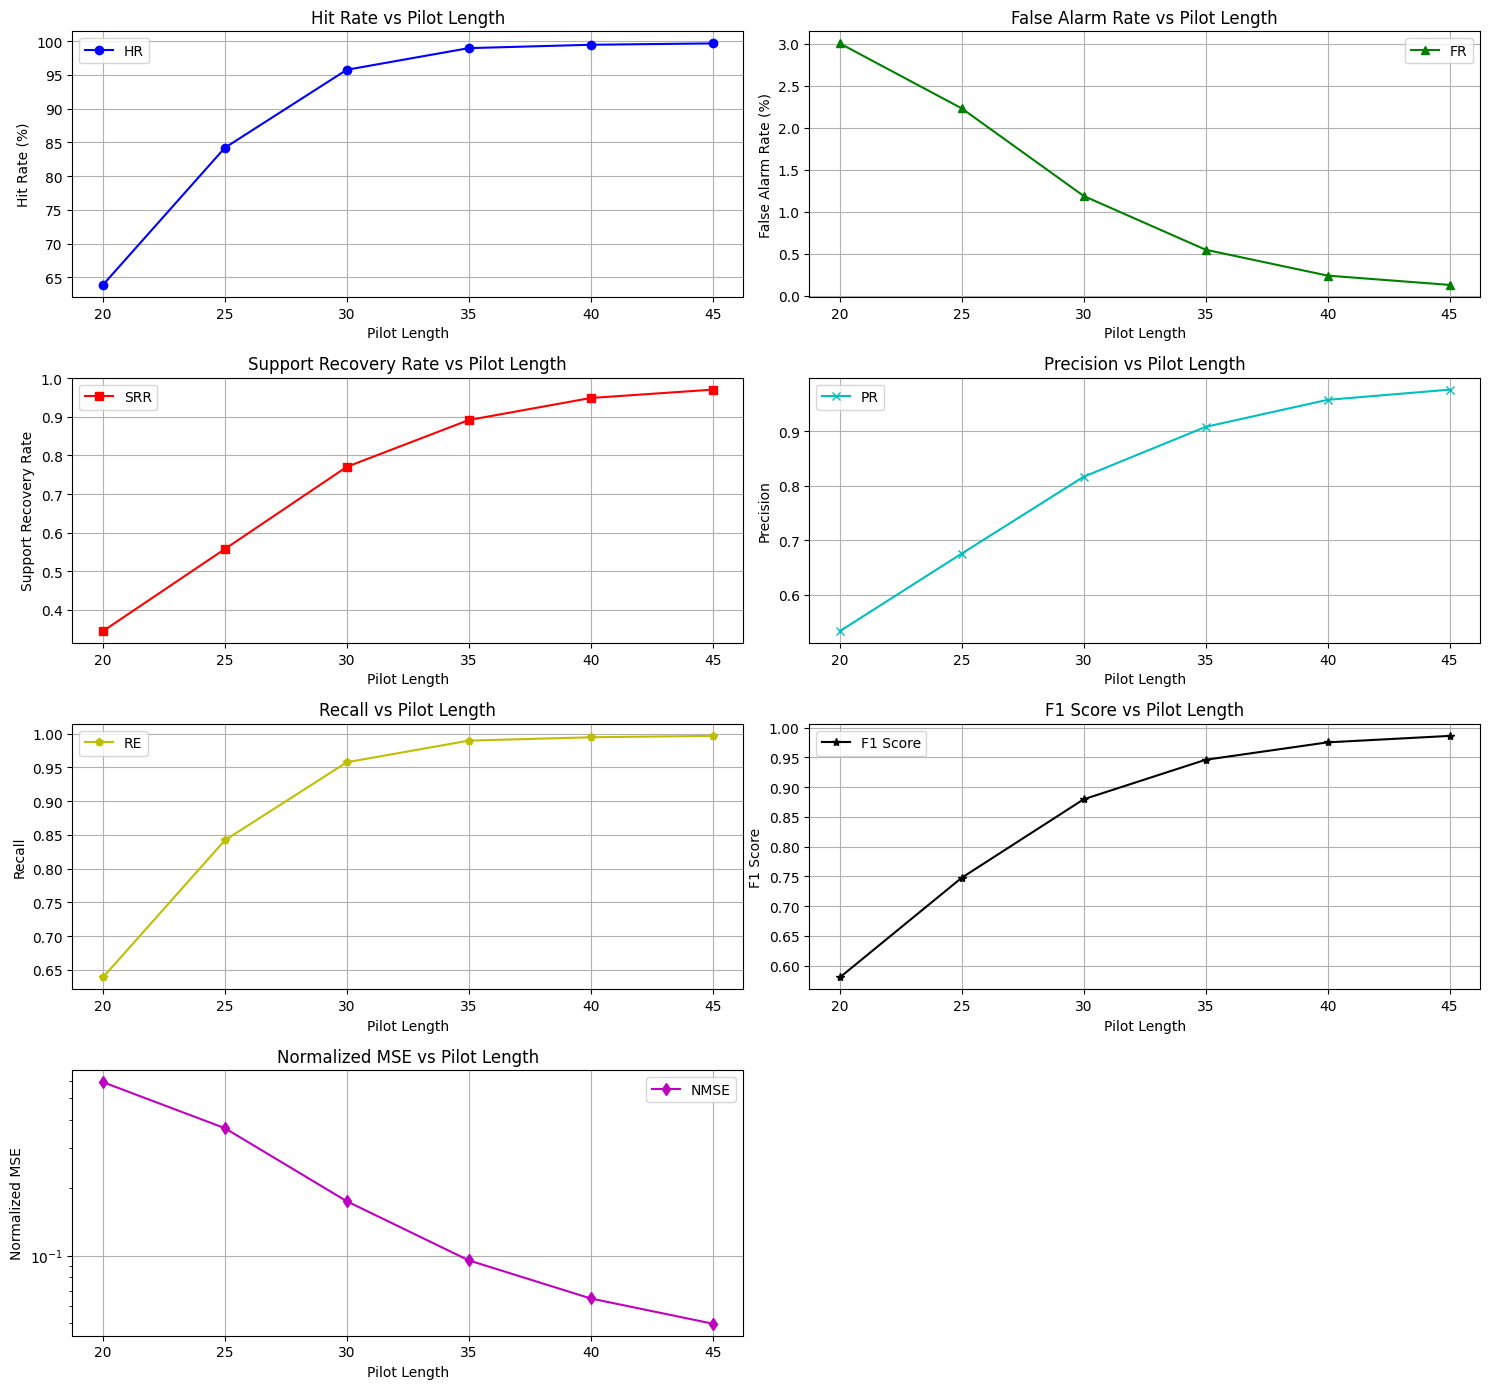

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

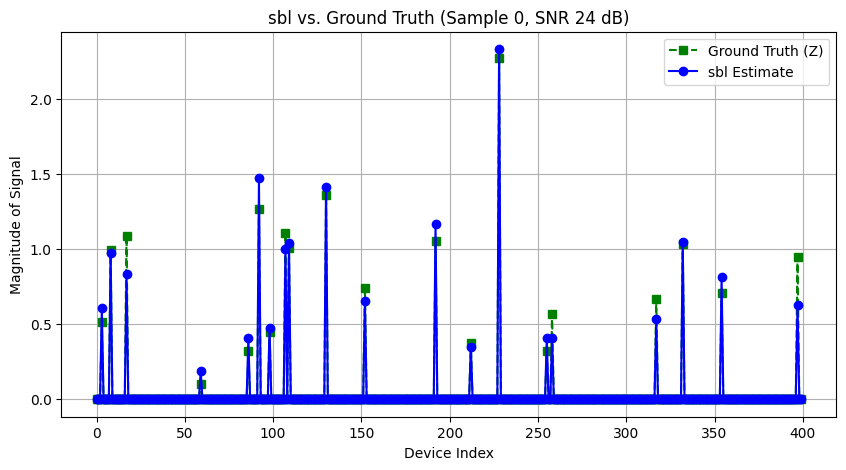

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


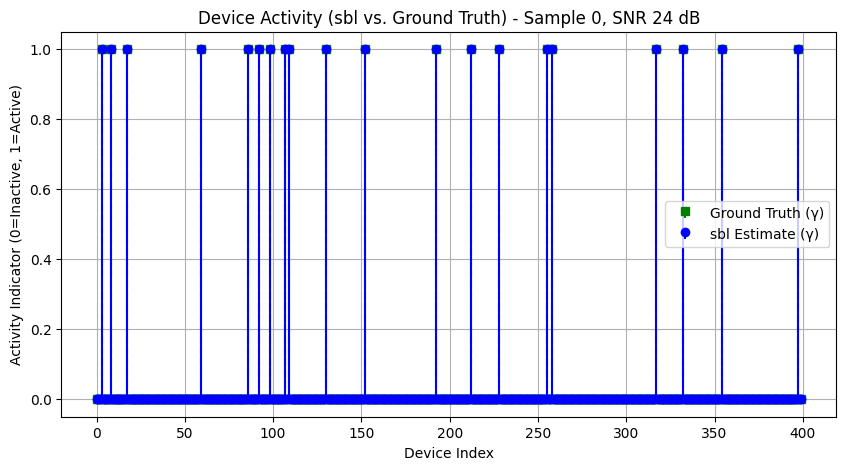

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)